## Construcción del modelo

In [ ]:
# Importar librerías esenciales para procesamiento de datos, visualización y ML
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Importar funciones de validación cruzada y métricas de evaluación
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Importar componentes de Hugging Face para trabajar con BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
# Definir configuración global del modelo
MODEL_NAME = "bert-base-uncased"  # Modelo BERT preentrenado a utilizar
MAX_LEN = 192                      # Longitud máxima de tokens para tokenización
SEED = 42                          # Semilla para reproducibilidad de resultados

In [ ]:
# Cargar dataset desde archivo CSV
df = pd.read_csv(r"C:\Users\xavir\Downloads\complaints_processed.csv")

# Seleccionar solo las columnas de categoría de producto y narrativa de queja
df = df[["product", "narrative"]].copy()

# Limpiar espacios en blanco y valores nulos en ambas columnas
df["product"] = df["product"].astype(str).str.strip()
df["narrative"] = df["narrative"].astype(str).fillna("").str.strip()

# Filtrar filas sin datos válidos en ambas columnas
df = df[(df["product"] != "") & (df["narrative"] != "")]

# Eliminar duplicados y reiniciar índices
df = df.drop_duplicates().reset_index(drop=True)

# Crear mapeo de etiquetas (categorías) a índices numéricos para clasificación
labels = sorted(df["product"].unique())
label2id = {lab: i for i, lab in enumerate(labels)}  # Etiqueta -> ID
id2label = {i: lab for lab, i in label2id.items()}   # ID -> Etiqueta

# Mapear las etiquetas de texto a sus correspondientes IDs numéricos
df["label"] = df["product"].map(label2id).astype(int)

# Mostrar información del dataset
print("Clases:", labels)
print("N:", len(df))
df.head()

Clases: ['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']
N: 124676


,product,narrative,label
0,credit_card,purchase order day shipping amount receive pro...,0
1,credit_card,forwarded message date tue subject please inve...,0
2,retail_banking,forwarded message cc sent friday pdt subject f...,4
3,credit_reporting,payment history missing credit report speciali...,1
4,credit_reporting,payment history missing credit report made mis...,1


In [ ]:
# Preparar datos para entrenamiento del modelo
X = df["narrative"].tolist()  # Textos de entrada
y = df["label"].tolist()      # Etiquetas de salida

# Dividir datos en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y if len(labels) > 1 else None
)

# Dividir el conjunto de entrenamiento en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=SEED, stratify=y_train if len(labels) > 1 else None
)

# Mostrar tamaños de los conjuntos de datos
len(X_train), len(X_val), len(X_test)

(79792, 19948, 24936)

In [ ]:
# Cargar tokenizador preentrenado de BERT
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Clase personalizada para convertir textos a datasets compatible con PyTorch
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Retornar el número total de muestras en el dataset
    def __len__(self):
        return len(self.texts)

    # Obtener una muestra tokenizada y etiquetada por índice
    def __getitem__(self, i):
        # Tokenizar el texto con truncamiento y padding
        enc = self.tokenizer(
            self.texts[i],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        # Eliminar dimensión extra de batch
        item = {k: v.squeeze(0) for k, v in enc.items()}
        # Agregar la etiqueta como tensor numérico
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

# Crear instancias de datasets para entrenamiento, validación y prueba
train_ds = TextDataset(X_train, y_train, tokenizer, MAX_LEN)
val_ds   = TextDataset(X_val, y_val, tokenizer, MAX_LEN)
test_ds  = TextDataset(X_test, y_test, tokenizer, MAX_LEN)

In [ ]:
# Función para visualizar la matriz de confusión con opciones de normalización
def plot_confusion_matrix(cm, labels, normalize=True, title="Confusion Matrix"):
    cm_plot = cm.astype(float)

    # Normalizar la matriz por filas si se especifica
    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        cm_plot = np.divide(cm_plot, row_sums, out=np.zeros_like(cm_plot), where=row_sums!=0)

    # Crear figura y mostrar matriz como imagen
    fig = plt.figure(figsize=(9, 7))
    plt.imshow(cm_plot)
    plt.title(title)
    plt.colorbar()

    # Configurar etiquetas de ejes con nombres de clases
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha="right")
    plt.yticks(tick_marks, labels)

    # Agregar valores de células en la matriz con color adaptado al fondo
    thresh = cm_plot.max() * 0.6
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            value = cm_plot[i, j]
            txt = f"{value:.2f}" if normalize else f"{int(value)}"
            plt.text(
                j, i, txt,
                ha="center", va="center",
                color="white" if value > thresh else "black",
                fontsize=9
            )

    # Etiquetar ejes y ajustar layout
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    return fig

In [ ]:
# Cargar modelo BERT preentrenado configurado para clasificación multiclase
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),     # Número de categorías a clasificar
    id2label=id2label,          # Mapeo de IDs a etiquetas de texto
    label2id=label2id           # Mapeo de etiquetas de texto a IDs
)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1562.36it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those p

In [ ]:
# Función para calcular métricas de evaluación (Accuracy y F1-Score macro)
def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    # Obtener predicciones de los logits (índice de máximo valor)
    y_pred = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
    }

# Configurar argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./bert_product_cls",     # Directorio para guardar checkpoints
    eval_strategy="epoch",               # Evaluar al final de cada época
    save_strategy="epoch",               # Guardar modelo al final de cada época
    load_best_model_at_end=True,         # Cargar mejor modelo al finalizar
    metric_for_best_model="f1_macro",    # Métrica para seleccionar mejor modelo
    greater_is_better=True,              # Maximizar F1-Score
    learning_rate=2e-5,                  # Tasa de aprendizaje (típica para BERT)
    per_device_train_batch_size=16,      # Tamaño de batch para entrenamiento
    per_device_eval_batch_size=32,       # Tamaño de batch para evaluación
    num_train_epochs=3,                  # Número de épocas
    weight_decay=0.01,                   # Regularización L2
    logging_steps=20,                    # Log cada 20 pasos
    seed=SEED,                           # Semilla para reproducibilidad
    report_to="none",                    # No reportar a servicios externos
)

# Crear entrenador de Hugging Face
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,           # Dataset de entrenamiento
    eval_dataset=val_ds,              # Dataset de validación
    compute_metrics=compute_metrics   # Función para calcular métricas
)

# Ejecutar entrenamiento
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.368369,0.407785,0.854722,0.841417
2,0.309143,0.390681,0.863495,0.850807
3,0.254944,0.425994,0.866804,0.852160


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer

TrainOutput(global_step=14961, training_loss=0.365122963100359, metrics={'train_runtime': 2941.4862, 'train_samples_per_second': 81.379, 'train_steps_per_second': 5.086, 'total_flos': 2.3619063176423424e+16, 'train_loss': 0.365122963100359, 'epoch': 3.0})

TEST accuracy: 0.8681
TEST f1_macro: 0.8531

Confusion matrix:
 [[ 2442   257    64    30   212]
 [  196 10394   455   173    43]
 [  106   625  3325   136    31]
 [   61   419   134  3063    75]
 [  167    38    19    47  2424]]


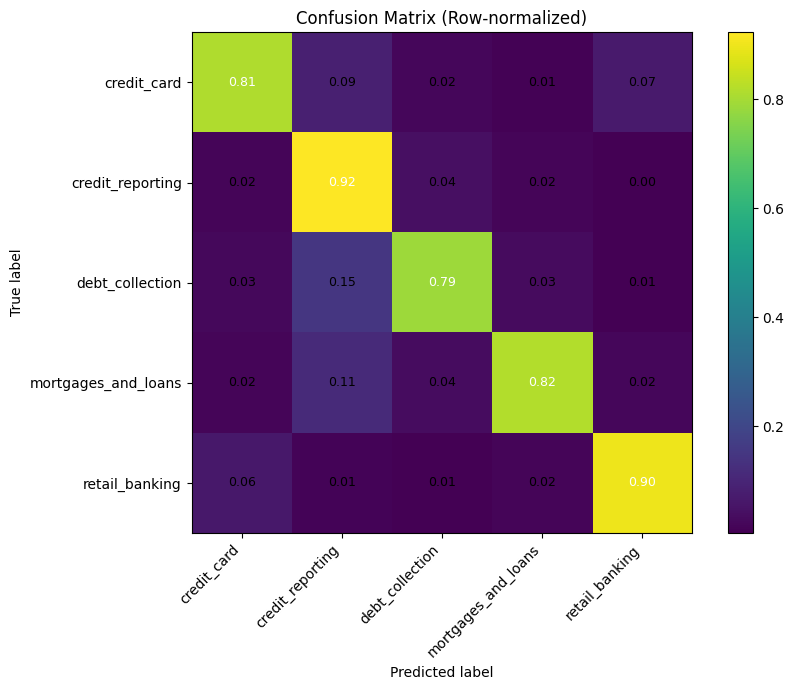

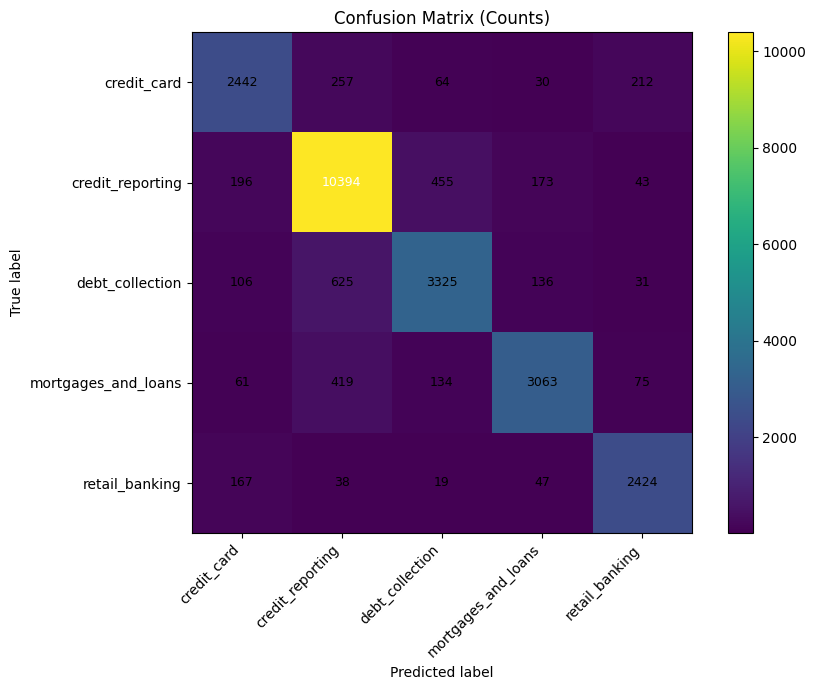


Report:
                      precision    recall  f1-score   support

        credit_card     0.8217    0.8126    0.8171      3005
   credit_reporting     0.8859    0.9230    0.9041     11261
    debt_collection     0.8319    0.7874    0.8090      4223
mortgages_and_loans     0.8881    0.8164    0.8507      3752
     retail_banking     0.8704    0.8994    0.8847      2695

           accuracy                         0.8681     24936
          macro avg     0.8596    0.8478    0.8531     24936
       weighted avg     0.8677    0.8681    0.8674     24936



In [ ]:
# Realizar predicciones en el conjunto de prueba
pred = trainer.predict(test_ds)
logits = pred.predictions              # Salidas del modelo (logits)
y_true = pred.label_ids                # Etiquetas verdaderas
y_pred = np.argmax(logits, axis=1)     # Predicciones (índice máximo de logits)

# Calcular métricas de desempeño
acc = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average="macro")
cm  = confusion_matrix(y_true, y_pred)

# Mostrar resultados de evaluación
print(f"TEST accuracy: {acc:.4f}")
print(f"TEST f1_macro: {f1m:.4f}")
print("\nConfusion matrix:\n", cm)

# Visualizar matriz de confusión normalizada por filas
fig_cm = plot_confusion_matrix(
    cm,
    labels,
    normalize=True,
    title="Confusion Matrix (Row-normalized)"
)
plt.show()

# Visualizar matriz de confusión con conteos absolutos
fig_cm_counts = plot_confusion_matrix(
    cm,
    labels,
    normalize=False,
    title="Confusion Matrix (Counts)"
)
plt.show()

# Mostrar reporte detallado de clasificación por clase
print("\nReport:\n", classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(labels))], digits=4))

In [ ]:
# Función para predecir la categoría de un texto individual
def predict_product(text: str, top_k: int = 3):
    # Tokenizar el texto de entrada
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LEN)
    
    # Mover tensores al dispositivo del modelo (GPU o CPU)
    enc = {k: v.to(trainer.model.device) for k, v in enc.items()}

    # Realizar inferencia sin calcular gradientes
    with torch.no_grad():
        out = trainer.model(**enc)
        # Convertir logits a probabilidades usando softmax
        probs = torch.softmax(out.logits, dim=1).cpu().numpy().ravel()

    # Obtener top-k predicciones ordenadas por confianza
    top_idx = probs.argsort()[::-1][:top_k]
    return [(id2label[int(i)], float(probs[int(i)])) for i in top_idx]

# Probar predicción con un ejemplo
predict_product("I was charged again after the refund and the dispute was denied.", top_k=3)

[('credit_card', 0.7326005697250366),
 ('mortgages_and_loans', 0.12017758935689926),
 ('debt_collection', 0.05935894325375557)]

In [ ]:
# Importar utilidades para manejo de rutas y JSON
from pathlib import Path
import json

# Crear directorio para almacenar artefactos del modelo
ARTIFACT_DIR = Path("./artifacts/bert_product_cls_v1")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# Guardar el modelo entrenado
trainer.model.save_pretrained(ARTIFACT_DIR)

# Guardar el tokenizador
tokenizer.save_pretrained(ARTIFACT_DIR)

# Guardar mapeos de etiquetas (CRÍTICO para inferencia posterior)
with open(ARTIFACT_DIR / "label_map.json", "w", encoding="utf-8") as f:
    json.dump(
        {"label2id": label2id, "id2label": id2label},
        f,
        ensure_ascii=False,
        indent=2
    )

print("Modelo y tokenizer guardados en:", ARTIFACT_DIR.resolve())

# Importar función de reporte de clasificación
from sklearn.metrics import classification_report

# Generar reporte de clasificación detallado en formato diccionario
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(len(labels))],
    digits=4,
    output_dict=True
)

# Compilar métricas de prueba y confusión en diccionario
metrics = {
    "test_accuracy": float(acc),
    "test_f1_macro": float(f1m),
    "labels": labels,
    "confusion_matrix": cm.tolist(),
    "classification_report": report_dict,
}

# Guardar métricas en archivo JSON
with open(ARTIFACT_DIR / "metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

# Guardar reporte de clasificación en formato texto
with open(ARTIFACT_DIR / "classification_report.txt", "w", encoding="utf-8") as f:
    f.write(
        classification_report(
            y_true,
            y_pred,
            target_names=[id2label[i] for i in range(len(labels))],
            digits=4
        )
    )

print("Métricas guardadas.")

# Guardar visualizaciones de matrices de confusión como imágenes
fig_cm.savefig(
    ARTIFACT_DIR / "confusion_matrix_normalized.png",
    dpi=200,
    bbox_inches="tight"
)

fig_cm_counts.savefig(
    ARTIFACT_DIR / "confusion_matrix_counts.png",
    dpi=200,
    bbox_inches="tight"
)

print("Figuras guardadas.")

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Modelo y tokenizer guardados en: C:\Users\xavir\OneDrive\Escritorio\Xavier Ramos\Maestría IA aplicada\Maestria-IA-Aplicada\Procesamiento de Lenguaje Natural\artifacts\bert_product_cls_v1
Métricas guardadas.
Figuras guardadas.


## Uso del modelo construido

In [ ]:
# Importar dependencias necesarias para cargar y usar el modelo
from pathlib import Path
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd

In [ ]:
# Función para cargar el modelo y componentes relacionados desde archivos guardados
def load_classifier(artifact_dir: Path):
    artifact_dir = Path(artifact_dir)

    # Cargar el tokenizador preentrenado
    tokenizer = AutoTokenizer.from_pretrained(artifact_dir)
    
    # Cargar el modelo BERT entrenado
    model = AutoModelForSequenceClassification.from_pretrained(artifact_dir)

    # Cargar mapeos de etiquetas desde archivo JSON
    with open(artifact_dir / "label_map.json", "r", encoding="utf-8") as f:
        maps = json.load(f)

    # Convertir claves de id2label de string a int (si es necesario desde JSON)
    id2label = {int(k): v for k, v in maps["id2label"].items()}
    # Convertir valores de label2id a int
    label2id = {k: int(v) for k, v in maps["label2id"].items()}

    # Detectar y usar GPU si está disponible, sino usar CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)           # Mover modelo al dispositivo
    model.eval()               # Cambiar a modo evaluación (sin dropout, batch norm fijo)

    return model, tokenizer, label2id, id2label, device

In [ ]:
# Función para realizar predicción en un texto individual
def predict_product(text: str, model, tokenizer, id2label, device, top_k: int = 3, max_len: int = 192):
    # Tokenizar el texto de entrada
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_len
    )
    # Mover tensores al dispositivo del modelo
    enc = {k: v.to(device) for k, v in enc.items()}

    # Realizar inferencia sin cálculo de gradientes
    with torch.no_grad():
        logits = model(**enc).logits
        # Convertir logits a probabilidades normalizadas
        probs = torch.softmax(logits, dim=1).cpu().numpy().ravel()

    # Obtener índices de las top-k predicciones ordenadas por confianza
    top_idx = probs.argsort()[::-1][:top_k]
    # Retornar tuples de (etiqueta, probabilidad) para top-k
    return [(id2label[int(i)], float(probs[int(i)])) for i in top_idx]

In [ ]:
# Función para realizar predicciones en batch (múltiples textos a la vez)
def predict_batch(texts, model, tokenizer, id2label, device, max_len: int = 192):
    # Tokenizar todos los textos en el batch
    enc = tokenizer(
        list(texts),
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_len
    )
    # Mover tensores al dispositivo del modelo
    enc = {k: v.to(device) for k, v in enc.items()}

    # Realizar inferencia en batch sin cálculo de gradientes
    with torch.no_grad():
        logits = model(**enc).logits
        # Convertir logits a probabilidades normalizadas
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    # Obtener predicción (clase) con mayor probabilidad para cada texto
    pred_ids = probs.argmax(axis=1)
    # Mapear IDs numéricos a etiquetas de texto
    pred_labels = [id2label[int(i)] for i in pred_ids]
    # Obtener confianza (probabilidad máxima) de cada predicción
    conf = probs.max(axis=1)

    # Retornar resultados en DataFrame con textos, predicciones y confianza
    return pd.DataFrame({
        "narrative": list(texts),
        "product_pred": pred_labels,
        "confidence": conf
    })

In [ ]:
# Especificar ruta del directorio con artefactos del modelo guardados
ARTIFACT_DIR = Path("./artifacts/bert_product_cls_v1")

In [ ]:
# Cargar el modelo y sus componentes relacionados desde archivos guardados
model, tokenizer, label2id, id2label, device = load_classifier(ARTIFACT_DIR)

# Confirmar que los artefactos fueron cargados exitosamente
print("Cargado OK desde:", ARTIFACT_DIR.resolve())
print("Device:", device)

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1239.07it/s, Materializing param=classifier.weight]                                      


Cargado OK desde: C:\Users\xavir\OneDrive\Escritorio\Xavier Ramos\Maestría IA aplicada\Maestria-IA-Aplicada\Procesamiento de Lenguaje Natural\artifacts\bert_product_cls_v1
Device: cuda


In [ ]:
# Realizar predicción individual en un texto de ejemplo
predict_product(
    "My payment history is missing from my credit report and I need it fixed urgently.",
    model, tokenizer, id2label, device, top_k=3
)

[('credit_reporting', 0.9801045656204224),
 ('debt_collection', 0.007578504737466574),
 ('mortgages_and_loans', 0.00679133553057909)]

In [ ]:
# Realizar predicciones en lote para múltiples textos de ejemplo
df_preds = predict_batch(
    [
        "I was charged again after my refund and the dispute was denied.",
        "Fraudulent debit card charges and the branch didn't solve it.",
        "My credit report shows missing payment history after a mistake."
    ],
    model, tokenizer, id2label, device
)
# Mostrar resultados en formato tabla
df_preds

,narrative,product_pred,confidence
0,I was charged again after my refund and the di...,credit_card,0.770395
1,Fraudulent debit card charges and the branch d...,retail_banking,0.746030
2,My credit report shows missing payment history...,credit_reporting,0.987899
